In [1]:
import os
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
import numpy as np
from nif.optimizers import AdaBeliefOptimizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import obspy
# plt.rc('text', usetex = True)
# plt.rc('font', family='serif')

2022-07-06 10:28:10.117949: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-06 10:28:11.160245: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-06 10:28:11.161140: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-06 10:28:11.182322: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-07-06 10:28:11.182342: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-06 10:28:11.184574: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11

1 Physical GPUs, 1 Logical GPUs


In [2]:
class SIREN(tf.keras.layers.Layer):
    def __init__(self, num_inputs, num_outputs, layer_position,
                 omega_0, mixed_policy=tf.keras.mixed_precision.Policy('float32'),
                 **kwargs):
        super(SIREN, self).__init__(**kwargs)
        self.layer_position = layer_position
        self.compute_Dtype = mixed_policy.compute_dtype
        variable_Dtype = mixed_policy.variable_dtype
        self.omega_0 = omega_0

        # initialize the weights
        if layer_position == 'first':
            w_init = tf.random.uniform((num_inputs, num_outputs),
                                       -1. / num_inputs,
                                       1. / num_inputs,
                                       dtype=variable_Dtype)
            b_init = tf.random.uniform((num_outputs,),
                                       -1. / np.sqrt(num_inputs),
                                       1. / np.sqrt(num_inputs),
                                       dtype=variable_Dtype)
        else:
            w_init = tf.random.uniform((num_inputs, num_outputs),
                                       -tf.math.sqrt(6.0 / num_inputs) / self.omega_0,
                                       tf.math.sqrt(6.0 / num_inputs) / self.omega_0,
                                       dtype=variable_Dtype)
            b_init = tf.random.uniform((num_outputs,),
                                       -1. / np.sqrt(num_inputs),
                                       1. / np.sqrt(num_inputs),
                                       dtype=variable_Dtype)


        self.w_init = w_init
        self.b_init = b_init
        self.w = tf.Variable(w_init, dtype=variable_Dtype, name=kwargs.get('name', 'siren') + '_w')
        self.b = tf.Variable(b_init, dtype=variable_Dtype, name=kwargs.get('name', 'siren') + '_b')

    def call(self, x, **kwargs):
        if self.layer_position == 'first' or self.layer_position == 'hidden':
            y = tf.math.sin(self.omega_0 * tf.matmul(x, tf.cast(self.w, self.compute_Dtype)) +
                            tf.cast(self.b, self.compute_Dtype))
        else:
            y = tf.matmul(x, tf.cast(self.w, self.compute_Dtype)) + tf.cast(self.b, self.compute_Dtype)
        return y

    def get_config(self):
        config = super().get_config()
        config.update({
            # "num_inputs": self.num_inputs,
            # "num_outputs": self.num_outputs,
            "layer_position": self.layer_position,
            "omega_0": self.omega_0,
            # "cfg_shape_net": self.cfg_shape_net,
            # "mixed_policy": self.mixed_policy
        })
        return config

    def get_prunable_weights(self):
        return [self.w]

In [8]:
XMIN =10000
XMAX = XMIN + 5000
DR_PATH = f"/data/wsd01/OOI-DAS-Data/1min/OOI-1min-raw-XMIN10000-XMAX15000.npz"
TRAIN_DATA = np.load(DR_PATH)['raw']
dmin = TRAIN_DATA.min()
dmax = TRAIN_DATA.max()

TRAIN_DATA = 2 *(TRAIN_DATA - dmin)/ (dmax - dmin) -1
NMIN = np.load(DR_PATH)['NMIN']

#---------
# load data
D_PATH = f"/data/wsd01/OOI-DAS-Data/1min/OOI-1min-rand500000-XMIN10000-XMAX15000.npz"
TRAIN_OBS = np.load(D_PATH)['obs'].reshape((-1, 1))
TRAIN_OBS = 2 *(TRAIN_OBS - dmin)/ (dmax - dmin) -1

X = np.load(D_PATH)['x'].reshape((-1, 1))
T = np.load(D_PATH)['t'].reshape((-1, 1))
NX = np.load(D_PATH)['NX']

train_data = np.concatenate([T, X, TRAIN_OBS], axis = -1)
print(f"total {NMIN} minutes data")
print(f"Data points/min for training: {len(train_data)/NMIN}")
print(f"Data maximum: {TRAIN_OBS.max()} | Data minimum: {TRAIN_OBS.min()}")

#---------
batch_size = 10000
num_total_data = train_data.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[:, :2],train_data[:, 2]))
train_dataset = train_dataset.shuffle(int(num_total_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

#--------
UNITS = 128
LAYERS = 8

# compile
optimizer = AdaBeliefOptimizer(2e-5)

# create the model
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(2,)))
model.add(SIREN(num_inputs=2, num_outputs=UNITS, layer_position='first', omega_0=100.0, name='first'))
for i in range(LAYERS):
    model.add(SIREN(num_inputs=UNITS, num_outputs=UNITS, layer_position='hidden', omega_0=100.0, name='hidden_{}'.format(i)))
model.add(SIREN(num_inputs=UNITS, num_outputs=1, layer_position='last', omega_0=100.0, name='last'))

model.compile(optimizer=optimizer, loss='mse')
history_callback = tf.keras.callbacks.History()

#------------
callbacks = [history_callback]
t = time.time()
nepoch = 15
model.fit(train_dataset, epochs=nepoch, callbacks=callbacks, use_multiprocessing = True, shuffle = True)
print(f"took {(time.time() - t)/nepoch} for {nepoch} epoch")

total 1 minutes data
Data points/min for training: 500000.0
Data maximum: 0.9889774804032743 | Data minimum: -0.9884602492385696
Epoch 1/15
50/50 [==============================] - 3s 20ms/step - loss: 0.1989
Epoch 2/15
50/50 [==============================] - 1s 18ms/step - loss: 0.1373
Epoch 3/15
50/50 [==============================] - 1s 17ms/step - loss: 0.0505
Epoch 4/15
50/50 [==============================] - 1s 19ms/step - loss: 0.0211
Epoch 5/15
50/50 [==============================] - 1s 18ms/step - loss: 0.0115
Epoch 6/15
50/50 [==============================] - 1s 17ms/step - loss: 0.0073
Epoch 7/15
50/50 [==============================] - 1s 18ms/step - loss: 0.0053
Epoch 8/15
50/50 [==============================] - 1s 18ms/step - loss: 0.0042
Epoch 9/15
50/50 [==============================] - 1s 18ms/step - loss: 0.0035
Epoch 10/15
50/50 [==============================] - 1s 17ms/step - loss: 0.0030
Epoch 11/15
50/50 [==============================] - 1s 17ms/step - lo

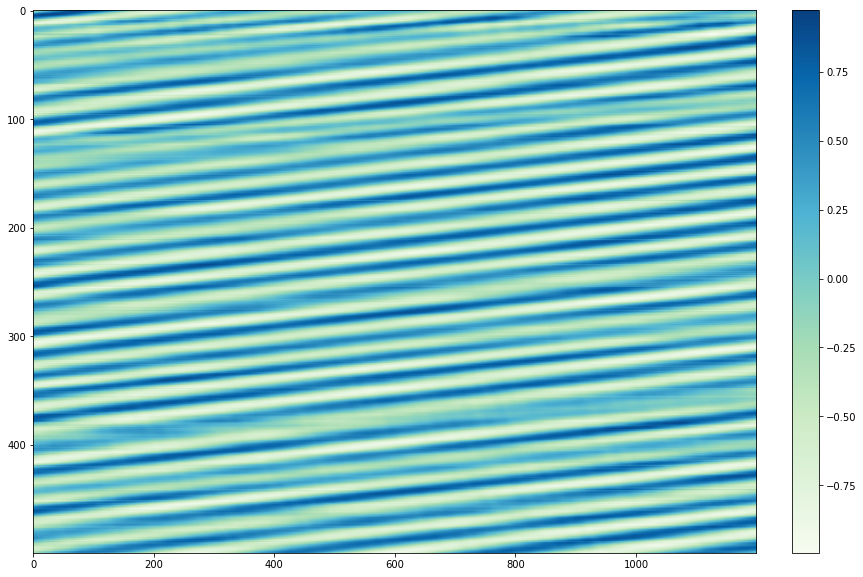

In [9]:
fig, ax = plt.subplots(figsize = (16, 10))
plt.imshow(TRAIN_DATA[::10, ::10], cmap = 'GnBu', aspect = 1.8)
plt.colorbar(ax = ax, pad = 0.04)

Text(0.5, 0, 'Channel')

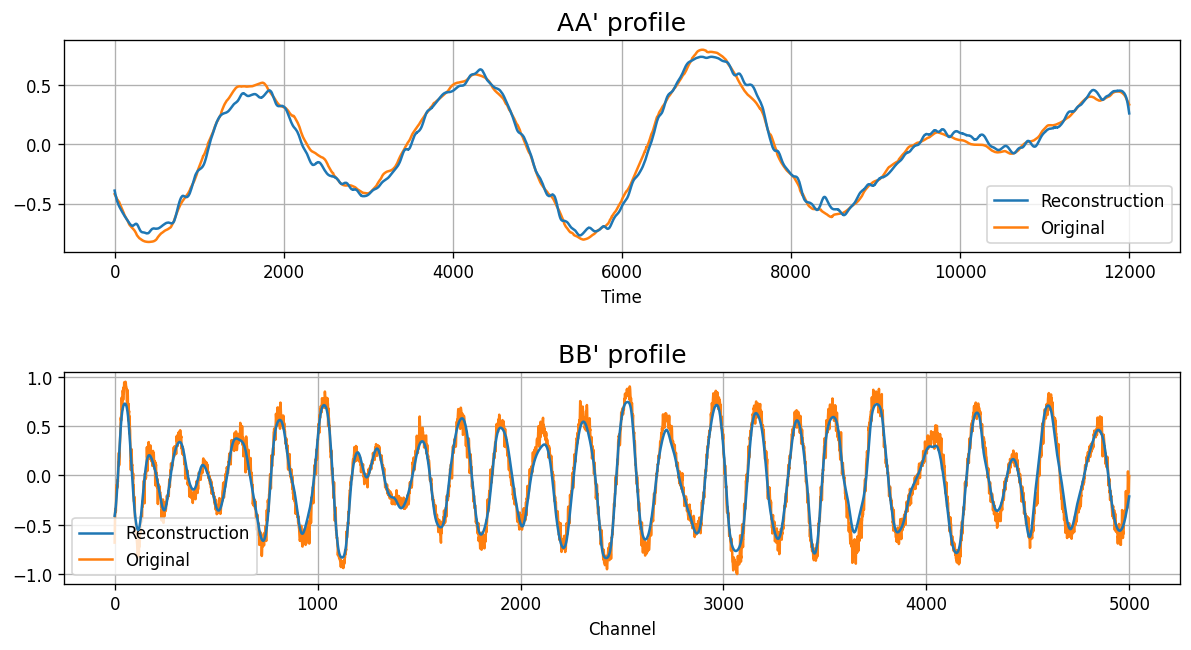

In [10]:
IT = 0; IX = 100; DNT = 1; DNX = 1; NT = 12000; DT = 2 / (NMIN * NT)
x = np.linspace(-1, 1, NX)
x = x[::DNX]
t = np.linspace(-1, 1 - DT, NT)

fig = plt.figure(figsize = (12, 6), dpi = 120)
plt.subplots_adjust(hspace = 0.57)
plt.subplot(2, 1, 1)

d = np.stack([t[::DNT], x[IX] * np.ones(int(NT/DNT))], axis = -1)
aa = model.predict(d).reshape(1, int(NT/DNT), 1)[:, :, 0]
plt.plot(aa.T, label = 'Reconstruction', zorder = 9)
plt.plot(TRAIN_DATA[IX*DNX, ::DNT], label = 'Original')

# plt.plot(np.diff(result_section)[0], label = 'Gradient Reconstruction', zorder = 9)
# plt.plot(np.diff(TRAIN_DATA[IX*DNX, ::DNT]), label = 'Gradient Original')

plt.grid(True)
# plt.xlim([4600, 5000])
plt.title("AA' profile", fontsize = 15)
plt.legend(fontsize = 10)
plt.xlabel("Time", fontsize = 10)

plt.subplot(2, 1, 2)
d = np.stack([t[IT]* np.ones(int(NX/DNX)), x], axis = -1)
bb = model.predict(d).reshape(1, int(NX/DNX), 1)[:, :, 0]
plt.plot(bb.T, label = 'Reconstruction', zorder = 9)
plt.plot(TRAIN_DATA[::DNX, IT], label = 'Original')

# plt.plot(np.diff(result_section)[0], label = 'Gradient Reconstruction', zorder = 9)
# plt.plot(np.diff(TRAIN_DATA[::DNX, IT]), label = 'Gradient Original')

plt.legend(loc = 'upper right')
plt.grid(True)
plt.title("BB' profile", fontsize = 15)
plt.legend(fontsize = 10)
plt.xlabel("Channel", fontsize = 10)

# plt.savefig(f"./profile.pdf", bbox_inches = 'tight', dpi = 300)
# plt.close()

In [12]:
d = np.load("/home/niyiyu/Research/DAS-NIF/smoothed_data//gaussian_smoothed_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z_channels_10000to15000_0.npy")

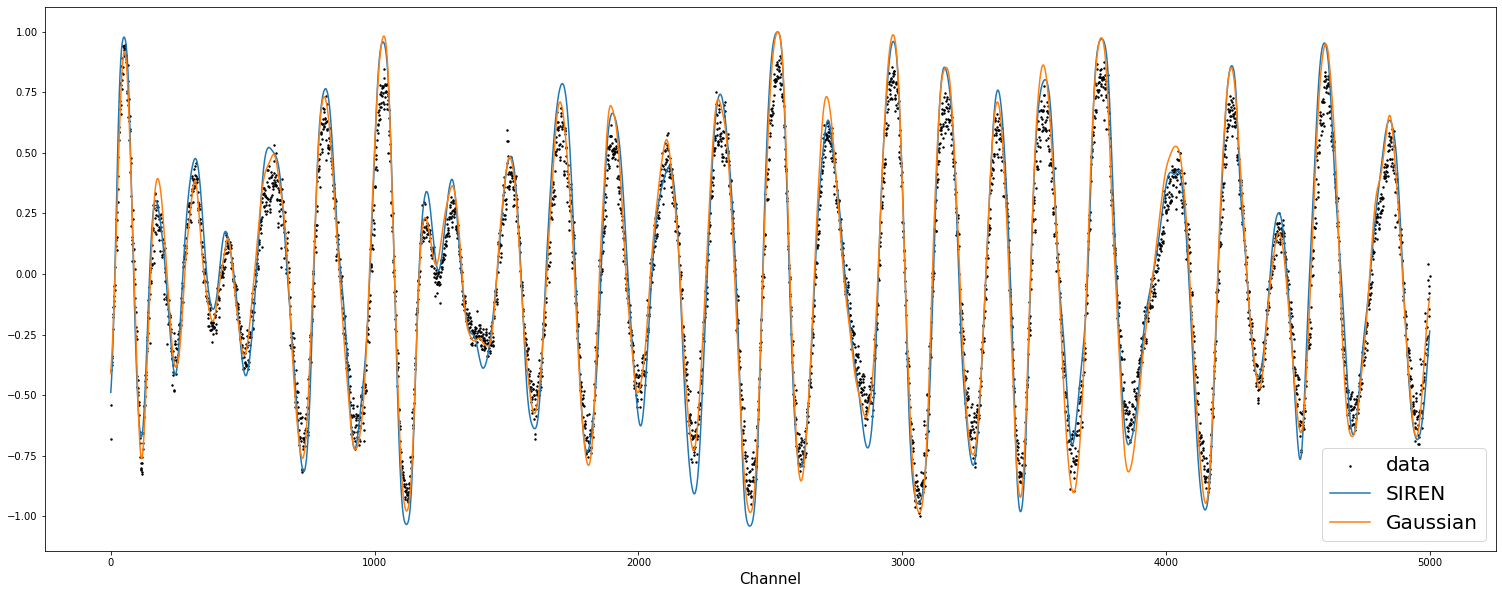

In [15]:
x = np.arange(len(TRAIN_DATA[::DNX, IT]))
fig=plt.figure(figsize=(26,10))
plt.scatter(x, TRAIN_DATA[::DNX, IT],s=2,c='k',label='data')
plt.plot((bb[0,:] - np.mean(bb[0, :]))/max(bb[0,:] - np.mean(bb[0, :])), label = 'SIREN')
plt.plot((d[0,:] - np.mean(d[0, :]))/max(d[0,:] - np.mean(d[0, :])), label = 'Gaussian')
plt.xlabel("Channel", fontsize = 15)
plt.legend(fontsize=20)
plt.show()